# HW1: CSCE-689-603

### Q1.	What is the AUROC for this dataset? (you can use built-in packages to generate this answer, but show what package and how you used it)?

In [75]:
#import required libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

In [76]:
#loading datasets
Probs = pd.read_csv('HW1probs.csv')
Labels = pd.read_csv('HW1Labels.csv')

#creating arrays
y_true = np.array(Labels.x) # true labels
y_probs = np.array(Probs.x) # predicted results

In [77]:
#Function to print ROC Curve and AUROC
def plotROC(false_positive_rate, true_positive_rate):
    """
    Prints ROC curve and AUROC.
    """
    # Print AUC
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    print('AUROC = %0.5f'% roc_auc)
    
    #Plot ROC curve
    plt.title('ROC Curve')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUROC = %0.5f'% roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    return plt

AUROC = 0.79377


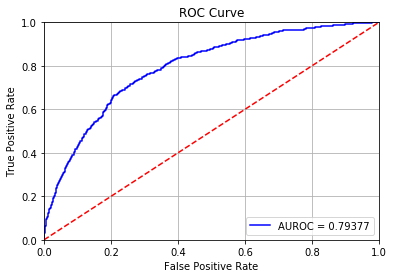

In [78]:
#arrays to store FPRs, TPRs and thresholds values
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true, y_probs)
plotROC(false_positive_rate, true_positive_rate).show()

**Ans1.** AUROC for the given dataset= 0.79377

---

### Q2.	At a 50% threshold, what are the True Positive, True Negative, False Positive, False Negative, Precision, Recall, F-score, Sensitivity, and Specificity? (you should be able to write code that generates these from the vectors, do not use pre-built metric packages)

In [79]:
#Function to calculates test metrics

def test_metrics(y_true, y_probs, thres):
    """Function to evaluate test metrics at a given threshold.

    Args:
        y_true: List of ground truth values
        y_probs: List of predicted/probabilistic output values
        thres: Threshold value

    Returns:
        comma-seperated TPs, FPs, FNs, TNs, TPRs,TNRs, precison, recall, F1

    """
    y_hat = (y_probs > thres).astype(np.int_)
    TP = sum((y_hat == y_true) & (y_true==1))
    FP = sum((y_hat==1) & (y_true==0))
    FN = sum((y_hat==0) & (y_true==1))
    TN = sum((y_hat == y_true) & (y_true==0))
    
    #sensitivity aka TPR
    TPR = TP/float(TP +FN) if TP!=0 else 0  
    #specificity aka TNR
    TNR = TN/float(TN + FP) if TN!=0 else 0    
    prec = TP/float(TP+FP) if TP!=0 else 0  #to handle divide by zero 
    rec = TPR 
    F1 = 2*prec*rec/(prec +rec) if prec!=0 else 0
    
    return(TP, FP, FN, TN, TPR,TNR, prec, rec, F1)

In [80]:
#Calculating test metrics at Threshold = 0.5

(TP, FP, FN, TN, TPR,TNR, prec, rec, F1) = test_metrics(y_true, y_probs, 0.5)

print "At threshold="+str(0.5)+": \n True Positives="+str(TP)+" \n True Negatives="+str(TN)+ \
      "\n False Positives="+str(FP) +" \n False Negatives="+str(FN)+ " \n Precision="+str(prec)+" \n Recall="+str(rec)+ \
      " \n Sensitivity="+str(TPR)+ " \n Specificity="+str(TNR)

At threshold=0.5: 
 True Positives=111 
 True Negatives=3042
 False Positives=82 
 False Negatives=497 
 Precision=0.575129533679 
 Recall=0.182565789474 
 Sensitivity=0.182565789474 
 Specificity=0.973751600512


---

<h3> Q3.	3.	Write a function that finds the optimal threshold for decision making (above which is a 1, below which is a 0). This function should have the following properties:
<br>
<br>
Function Name: optimalROCPoint
<br>
Input: ground truth vector, predicted probability vector, number of points to consider (default of 1000), Condition to Optimize
<br>
<br>
Output:
<br>
1) The TP, FP, TN, FN, Precision, Recall, Sensitivity, Specificity, TPR, FPR, and F-score for each threshold tested (for example, of the 1000)
<br>
2) The Optimal threshold (if multiple exists, you can choose to output all of them, randomly choose one, or always output the first) Some things that will help simplify this function: Conditions to Optimize (maximize) will be limited to the list of the following:
<br>
1) F-score
<br>
2) Precision
<br>
<br>
Some things that will help simplify this function:
Conditions to Optimize (maximize) will be limited to the list of the following:
<br>
1) F-score
<br>
2) Precision
<br>
3) Recall
<br>
4) Sensitivity
<br>
5) Specificity
<br>
6) TPR given a maximum FPR threshold (this threshold must be provided)
<br>
7) Minimum FPR given a minimum TPR threshold (this threshold must be provided)
<br>
<br>
3) Self-check your Function by Plotting the TPR/FPR points and comparing this plot to an ROC plot

</h3>

In [81]:
def optimalROCPoint(y_true, y_probs, nums = 1000, cond=None, ip_thres =None): 
    """Function to evaluate optimal ROC point.
    Prints test-metrics values at list of threshold values.
    Prints optimal threshold values for the given condition.

    Args:
        y_true: List of ground truth values
        y_probs: List of predicted/probabilistic output values
        nums: number of threshold values
        cond: condition to optimize. One of "F-score", "recall", "sensitivity", "precision", "specificity", "TPR", "FPR"
        ip_thres: Threshold value for max FPR or min TPR which must be provided if condion TRP or FPR respectively.

    Returns:
        lists of FPR and TPR i.e. arr_FPR and arr_FPR for self-checking ROC

    """

    #generate threshold values between 0 and 1
    lower = 0
    upper = 1
    thresholds=[lower + (x+1)*(upper-lower)/float(nums) for x in range(nums)]
    
    opt_thres=0
    max_F1=0
    max_prec=0
    max_rec=0
    max_spec=0
    max_TPR =0
    min_FPR = 1
    
    if cond in ('TPR','FPR') and ip_thres==None:
        raise ValueError('Provide a value for "ip_thres" in the function call')
    
    arr_FPR=[]
    arr_TPR=[]
    
    for thres in thresholds:
        # Calculate metrics using function created in Q2
        (TP, FP, FN, TN, TPR,TNR, prec, rec, F1) = test_metrics(y_true, y_probs, thres)
        
        sens = TPR
        spec = TNR
        FPR = 1-TNR
        
        
        arr_FPR.append(FPR)
        arr_TPR.append(TPR)
        
        # Print metrics values at diffrent thresholds
        print("At threshold="+str(thres)+": \nTP="+str(TP)+" FP="+str(FP)+" FN="+str(FN) +" TN="+str(TN)+ \
              " TPR="+str(TPR)+" FPR="+str(FPR)+" Sensitivity="+str(sens)+ \
              " Specificity="+str(spec)+" Precision="+str(prec)+ \
              " Recall="+str(rec)+ " F1="+str(F1) +"\n\n")
        
        if cond=='F-score':
            if F1>max_F1:
                max_F1=F1
                opt_thres=thres
                
        if cond in ('recall','sensitivity'):
            if rec>max_rec:
                max_rec=rec
                opt_thres=thres
                
        if cond=='precision':
            if prec>max_prec:
                max_prec=prec
                opt_thres=thres
                
        if cond=='specificity':
            if spec>max_spec:
                max_spec=spec
                opt_thres=thres
        
        if cond=='TPR' and FPR<=ip_thres:
            if TPR>max_TPR:
                max_TPR=TPR
                opt_thres=thres
                
        if cond=='FPR' and TPR>=ip_thres:
            if FPR<min_FPR:
                min_FPR=FPR
                opt_thres=thres
                
    print("For the condition=" + cond +", the optimal threshold=" + str(opt_thres))
    
    return (arr_FPR,arr_TPR)

In [82]:
#cond can take one of the values: F-score, recall, sensitivity, precision, specificity, TPR, FPR
cond = 'precision'

#Arrays to self check the ROC

arr_FPR, arr_TPR=optimalROCPoint(y_true, y_probs,100,cond)

At threshold=0.01: 
TP=608 FP=3094 FN=0 TN=30 TPR=1.0 FPR=0.990396927017 Sensitivity=1.0 Specificity=0.00960307298335 Precision=0.164235548352 Recall=1.0 F1=0.282134570766


At threshold=0.02: 
TP=606 FP=2930 FN=2 TN=194 TPR=0.996710526316 FPR=0.937900128041 Sensitivity=0.996710526316 Specificity=0.062099871959 Precision=0.171380090498 Recall=0.996710526316 F1=0.292471042471


At threshold=0.03: 
TP=599 FP=2689 FN=9 TN=435 TPR=0.985197368421 FPR=0.860755441741 Sensitivity=0.985197368421 Specificity=0.139244558259 Precision=0.182177615572 Recall=0.985197368421 F1=0.30749486653


At threshold=0.04: 
TP=591 FP=2442 FN=17 TN=682 TPR=0.972039473684 FPR=0.781690140845 Sensitivity=0.972039473684 Specificity=0.218309859155 Precision=0.194856577646 Recall=0.972039473684 F1=0.324636088987


At threshold=0.05: 
TP=586 FP=2236 FN=22 TN=888 TPR=0.963815789474 FPR=0.715749039693 Sensitivity=0.963815789474 Specificity=0.284250960307 Precision=0.207654145996 Recall=0.963815789474 F1=0.341690962099


A

### Self-Checking the ROC plot

AUROC = 0.79377
AUROC = 0.78440


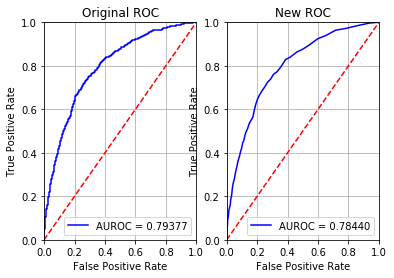

In [83]:
from pylab import *
subplot(1,2,1)
plotROC(false_positive_rate, true_positive_rate)
title('Original ROC')
 
subplot(1,2,2)
plotROC(arr_FPR, arr_TPR)
title('New ROC')

plt.show()